# Certifying coffee beans by using kShape algorithm

<div style="width: 130px ; float: right"><img src="https://bit.ly/2NlJd8X" alt="drawing"><p style="font-size: 10px ; text-align: center; margin: 0px 0px">Illustration by Shannon Wheeler (@muchcoffee)</p></div>
                                                                                   
Data sequence clustering algorithms groups series based on their shapes. An important feature regarding clustering algorithms is their ability to deal with subtle changes in shapes; in some cases, being able to identify small shape variations in a set is key to correctly produce the most appropriate clusters for our data. 

In this example, we use [Khiva's](https://khiva-python.readthedocs.io/en/latest/) implementation of [_kShape_](http://www.cs.columbia.edu/~gravano/Papers/2017/tods17.pdf) to classify coffee samples according to its variety. _kShape_ outperforms other algorithms like _kMeans_, as it obtains better results due to the lack of dependence on scale and shifting. In this use-case, we run both algorithms and compare their results.

We have chosen a [Coffee Dataset](http://www.timeseriesclassification.com/dataset.php) containing 28 series. Each series is obtained by a spectrograph and we have two possible coffee families in the set: Arabica or Robusta variety. Main differences between both varieties are shown below:



| Variety |          Taste         |              Look             |          Price               |   Chemistry  |
|--------:|-----------------------:|------------------------------:|-----------------------------:|:------------:|
| Robusta | Woody or burnt quality | Paler, more circular, smaller |      Generally cheaper       | 25% more caffeine and flavour compounds|
| Arabica | Sweet, higher acidity  |    Oval, generally larger     | About 3 times more expensive | Lower caffeine content  |


The objective of this use case is to use [Khiva's](https://khiva-python.readthedocs.io/en/latest/) implementation of [_kShape_](http://www.cs.columbia.edu/~gravano/Papers/2017/tods17.pdf) and _kMeans_ to cluster the results of the spectrograph.


In [1]:
#from khiva.library import 
import khiva as kv
from khiva.clustering import *
from khiva.array import Array
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from ipywidgets import interact, IntSlider

import numpy as np
import pandas as pd

In [2]:
def statistics(output, test_classes):
    equals = float(np.sum(output == test_classes))
    gttp = float(np.sum(test_classes == 1))  # could also use np.sum(test_classes) since elements are 0 and 1
    gttn = float(np.sum(test_classes == 0))  # Also: len(test_classes) - gttp because of binary classification

    # indexes of the 1s in output
    ind1_output = np.flatnonzero(output)

    # indexes of the 1s in test_classes
    ind1_test_classes = np.flatnonzero(test_classes)

    # indexes of the 0s in output
    ind0_output = np.where(output == 0)[0]  # returns a tuple. We extract the first and only element

    # indexes of the 0s in test_classes
    ind0_test_classes = np.where(test_classes == 0)[0]

    # Now we have the indexes of the elements in the results obtained and the ground_truth's
    true_positives = float(len(np.intersect1d(ind1_output, ind1_test_classes)))

    # false_positives = len(np.intersect1d(ind1_output, ind0_test_classes))

    true_negatives = float(len(np.intersect1d(ind0_output, ind0_test_classes)))

    # false_negatives = len(np.intersect1d(ind0_output, ind1_test_classes))
    
    accuracy = max(equals/len(output), 1-(equals/len(output)))

    print("Accuracy: " + str(accuracy))
    print("True positive: " + str(true_positives / gttp))
    print("True negative: " + str(true_negatives / gttn))
    print("False positive: " + str(1 - true_negatives / gttn))
    print("False negative: " + str(1 - true_positives / gttp))

## Visualising the dataset

Firstly, let's load the training dataset and plot all coffee samples in a single chart. 

As we can see, it is hardly impossible to perform an accurate classification by visual inspection, as there are no key differences between the two coffee families.

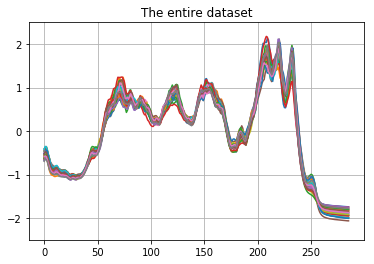

In [3]:
data = pd.read_csv("Coffee_TRAIN.txt", header=None, sep=' ')
data = data.values #from panda frama to numpy array

classes = data[:,0] # extracting the classes

data = np.delete(data, 0, 1) # data now contains only the time-series

f1, ax1 = plt.subplots()
ax1.set_ylim([-2.5, 2.5])
ax1.plot(data.T)
plt.title("The entire dataset")
plt.grid(True)

## Clustering using _kShape_
Let's run _kShape_ algorithm first.  _Khiva_ implementation will compute the centroids for each group automatically. These centroids keep the key characteristics for each group, like shift, scale and shape, thanks to a specialised data series distance metric called _SBD_ (in reality, it is a *dissimilarty* distance), which takes into account the actual shape of the series.

Move the slider button to change the number of iterations and check how this impact on _k-shapes_ accuracy! You can also analyse the statistics corresponding to this classification with a summary of results.


In [4]:
arr = Array(data) # passing the dataset to KHIVA_ARRAY

def k_shape_interaction(num_iter):
    (centroids, indexes) = k_shape(arr, 2, tolerance=10e-10, max_iterations=num_iter)
    ind = indexes.to_numpy()
    cen = centroids.to_numpy()

    f2, ax2 = plt.subplots()
    ax2.set_ylim([-2.5, 2.5])
    ax2.plot(cen.T)
    plt.title("Centroids with kShape")
    plt.grid(True)

    print("kShape Statistics:")
    statistics((ind)%2, classes)

interact(k_shape_interaction, num_iter=IntSlider(min=1, max=20, step=1), continuous_update=False)

interactive(children=(IntSlider(value=1, description='num_iter', max=20, min=1), Output()), _dom_classes=('wid…

<function __main__.k_shape_interaction(num_iter)>


## Clustering using _kMeans_

Now we are going to execute the same analysis but using Scikit's _kMeans_ implementation, so we can benchmark its accuracy against KShape.




kMeans Statistics

Accuracy: 0.9642857142857143
True positive: 1.0
True negative: 0.9285714285714286
False positive: 0.0714285714285714
False negative: 0.0


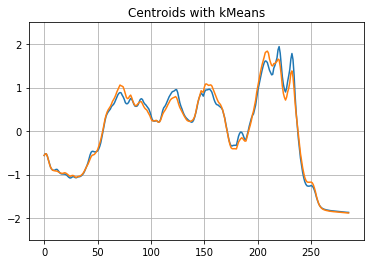

In [5]:
km = KMeans(n_clusters=2).fit(data)
f3, ax3 = plt.subplots()
ax3.set_ylim([-2.5, 2.5])
ax3.plot(km.cluster_centers_.T)
plt.title("Centroids with kMeans")
plt.grid(True)

print("\n\nkMeans Statistics\n")
statistics((km.labels_+1)%2, classes)

## Visualising the clusters with _kShape_
Now that we have computed the clusters using _kShape_, we can plot the time-series belonging to the first cluster, along with the first centroid (black line). Looking at the graph, it is easy to conclude that the centroid summarises the shape of all the time-series belonging to this first cluster. Besides, we show the analogue graph for the second cluster.

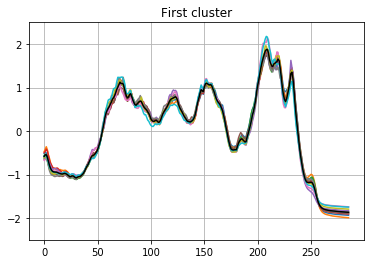

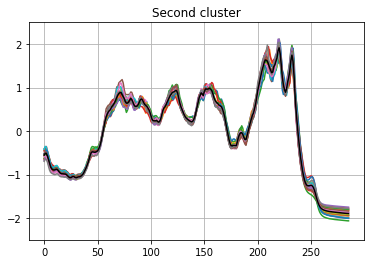

In [25]:
(centroids, indices) = k_shape(arr, 2, tolerance=10e-10, max_iterations=100)
cen = centroids.to_numpy()
ind = indices.to_numpy()
first_cluster = data[ind == 0]
f4, ax4 = plt.subplots()
ax4.set_ylim([-2.5, 2.5])

plt.plot(first_cluster.T)
plt.plot(cen[0, :], 'k')
plt.title("First cluster")
plt.grid(True)


second_cluster = data[ind == 1]
f5, ax5 = plt.subplots()
ax5.set_ylim([-2.5, 2.5])

plt.plot(second_cluster.T)
plt.plot(cen[1, :], 'k')
plt.title("Second cluster")
plt.grid(True)


## Loading the Testing Dataset
With the purpose to show how accurate the previous centroids summarise the clusters, we classify a new set of time-series, which conforms the testing dataset. The testing dataset is loaded and used with the previously computed centroids. Once the dataset is loaded, each time-series is assigned to a cluster based on the Euclidean distance algorithm method and, right after that, we use the [_NCC_](http://www.cs.columbia.edu/~gravano/Papers/2017/tods17.pdf) distance method.


In [26]:
def _ncc_c_3dim(x, y):
    den = np.linalg.norm(x, axis=1)[:, None] * np.linalg.norm(y, axis=1)
    den[den == 0] = np.Inf
    x_len = x.shape[-1]
    fft_size = 1 << (2*x_len-1).bit_length()
    cc = np.fft.ifft(np.fft.fft(x, fft_size) * np.conj(np.fft.fft(y, fft_size))[:, None])
    cc = np.concatenate((cc[:,:,-(x_len-1):], cc[:,:,:x_len]), axis=2)
    return np.real(cc) / den.T[:, :, None]

test = pd.read_csv("Coffee_TEST.txt", header = None, sep=' ')
test = test.values

test_classes = test[:,0]
test = np.delete(test, 0, 1)


distances = np.empty((cen.shape[0], test.shape[0]))

for i in range(test.shape[0]):
    for j in range(cen.shape[0]):
        distances[j, i] = np.sum(np.abs(test[i,:] - cen[j, :]))

idx_test = np.argmin(distances, 0)
print("\n\nTest Dataset with kShape centroids and Euclidean distance Statistics\n")
statistics(idx_test, test_classes)

distances_NCC = (1 - _ncc_c_3dim(test, cen).max(axis=2)).T
idx_test_ncc = distances_NCC.argmin(1)
print("\n\nTest Dataset with kShape centroids and NCC distance Statistics\n")
statistics(idx_test_ncc, test_classes)



Test Dataset with kShape centroids and Euclidean distance Statistics

Accuracy: 0.8571428571428571
True positive: 0.9230769230769231
True negative: 0.8
False positive: 0.19999999999999996
False negative: 0.07692307692307687


Test Dataset with kShape centroids and NCC distance Statistics

Accuracy: 0.8928571428571429
True positive: 1.0
True negative: 0.8
False positive: 0.19999999999999996
False negative: 0.0


Finally, we plot the time-series that have been assigned to the wrong cluster.

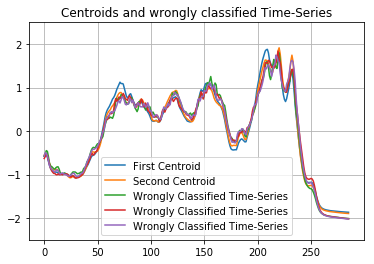

In [27]:
#Plotting the time-series that have not been properly classified..
failed_tss = test[(idx_test_ncc != test_classes)]

f6, ax6 = plt.subplots()
ax6.set_ylim([-2.5, 2.5])
plt.plot(cen[0, :], label="First Centroid")
plt.plot(cen[1, :], label="Second Centroid")
for i in range(failed_tss.shape[0]):
    plt.plot(failed_tss[i,:], label="Wrongly Classified Time-Series")
plt.title("Centroids and wrongly classified Time-Series")
plt.grid(True)
plt.legend()
plt.show()
f6.savefig("Wrongly_classified.png")

Considering the previous results, it becomes apparent that using a specialised algorithm for data series delivers better clustering insights, rather than those obtain using a more generalized algorithm like _kMeans_

Should you find these use cases interesting for your data, do please download Khiva and give it a spin;  don't forget to send us some feedback!! 